In [24]:
import math
import numpy as np
import time
import random
from collections import deque
import matplotlib.pyplot as plt

In [25]:
def read_coordinates(file_path):
    """
    Lee las coordenadas de las ciudades desde un archivo y las retorna como un diccionario.
    """
    cities = {}
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.strip() and not line.startswith("Qatar"):
                parts = line.split()
                city_id = int(parts[0])
                x, y = map(float, parts[1:])
                cities[city_id] = (x, y)
    return cities


def calculate_distance(coord1, coord2):
    """
    Calcula la distancia euclidiana redondeada entre dos puntos.
    """
    return int(round(math.sqrt((coord1[0] - coord2[0]) ** 2 + (coord1[1] - coord2[1]) ** 2)))


def create_distance_matrix(cities):
    """
    Crea una matriz de distancias entre todas las ciudades.
    """
    n = len(cities)
    distance_matrix = np.zeros((n, n), dtype=int)
    city_ids = list(cities.keys())
    for i in range(n):
        for j in range(n):
            if i != j:
                distance_matrix[i][j] = calculate_distance(cities[city_ids[i]], cities[city_ids[j]])
            else:
                distance_matrix[i][j] = 0  # Usar 0 para la diagonal principal
    return distance_matrix, city_ids

In [26]:
def nearest_neighbor_heuristic(distance_matrix, city_ids):
    """
    Aplica la heurística del vecino más cercano para aproximar la ruta del agente viajero.
    """
    n = len(city_ids)
    visited = [False] * n
    current_city = 0  # Empezar desde la primera ciudad
    route = [city_ids[current_city]]
    visited[current_city] = True
    total_distance = 0

    for _ in range(n - 1):
        nearest_city = None
        min_distance = float('inf')
        for next_city in range(n):
            if not visited[next_city] and distance_matrix[current_city][next_city] < min_distance:
                nearest_city = next_city
                min_distance = distance_matrix[current_city][next_city]

        route.append(city_ids[nearest_city])
        total_distance += min_distance
        visited[nearest_city] = True
        current_city = nearest_city

    # Volver a la ciudad inicial
    total_distance += distance_matrix[current_city][0]
    route.append(city_ids[0])

    return route, total_distance


In [27]:
def simulated_annealing(distance_matrix, city_ids, initial_temperature=1000000, cooling_rate=0.9999, max_iterations=100000000):
    """
    Implementa recocido simulado para resolver el problema del agente viajero.
    """
    def calculate_total_distance(route):
        total_distance = 0
        for i in range(len(route) - 1):
            total_distance += distance_matrix[route[i]][route[i + 1]]
        total_distance += distance_matrix[route[-1]][route[0]]  # Volver al inicio
        return total_distance

    def two_opt_swap(route):
        """
        Realiza un intercambio de segmento (2-opt) en la ruta.
        """
        i, j = sorted(random.sample(range(len(route)), 2))
        new_route = route[:]
        new_route[i:j + 1] = reversed(new_route[i:j + 1])
        return new_route

    # Generar solución inicial
    current_solution = list(range(len(city_ids)))
    random.shuffle(current_solution)
    current_distance = calculate_total_distance(current_solution)

    best_solution = current_solution[:]
    best_distance = current_distance

    temperature = initial_temperature

    for iteration in range(max_iterations):
        # Generar un vecino
        new_solution = two_opt_swap(current_solution)
        new_distance = calculate_total_distance(new_solution)

        # Calcular cambio de energía
        delta_energy = new_distance - current_distance

        # Decidir si aceptar el vecino
        if delta_energy < 0 or random.random() < math.exp(-delta_energy / temperature):
            current_solution = new_solution
            current_distance = new_distance

            # Actualizar la mejor solución
            if current_distance < best_distance:
                best_solution = current_solution[:]
                best_distance = current_distance

        # Enfriar la temperatura
        temperature *= cooling_rate

        # Terminar si la temperatura es muy baja
        if temperature < 1e-3:
            break

    # Convertir índices a IDs de ciudades
    final_route = [city_ids[i] for i in best_solution]
    return final_route, best_distance

In [28]:
def nearest_insertion_heuristic(distance_matrix, city_ids):
    """
    Aplica la heurística de inserción más cercana para aproximar la solución del agente viajero.
    """
    n = len(city_ids)
    visited = set()
    
    # Iniciar con un recorrido pequeño: dos primeras ciudades
    route = [0, 1, 0]  # Usamos índices de la matriz de distancias
    visited.update([0, 1])
    
    while len(visited) < n:
        # Buscar la ciudad no visitada más cercana a cualquier ciudad en la ruta actual
        nearest_city = None
        min_distance = float('inf')
        
        for city in range(n):
            if city not in visited:
                for r_city in route[:-1]:  # Excluir la última ciudad (que es igual a la inicial)
                    if distance_matrix[city][r_city] < min_distance:
                        min_distance = distance_matrix[city][r_city]
                        nearest_city = city

        # Insertar la ciudad más cercana en el mejor lugar del recorrido
        best_position = None
        min_increase = float('inf')
        for i in range(len(route) - 1):  # Iterar por pares consecutivos en la ruta
            current_city, next_city = route[i], route[i + 1]
            cost_increase = (
                distance_matrix[current_city][nearest_city]
                + distance_matrix[nearest_city][next_city]
                - distance_matrix[current_city][next_city]
            )
            if cost_increase < min_increase:
                min_increase = cost_increase
                best_position = i + 1
        
        # Insertar la ciudad en la posición óptima
        route.insert(best_position, nearest_city)
        visited.add(nearest_city)
    
    # Convertir índices a IDs de ciudades
    final_route = [city_ids[i] for i in route]
    total_distance = sum(
        distance_matrix[route[i]][route[i + 1]] for i in range(len(route) - 1)
    )
    return final_route, total_distance


In [29]:
def two_opt_heuristic(distance_matrix, city_ids):
    """
    Aplica la heurística 2-opt para mejorar una ruta inicial, 
    asegurando regresar a la ciudad inicial.
    """
    def calculate_total_distance(route):
        total_distance = 0
        for i in range(len(route) - 1):
            total_distance += distance_matrix[route[i]][route[i + 1]]
        total_distance += distance_matrix[route[-1]][route[0]]  # Volver al inicio
        return total_distance

    # Ruta inicial (orden natural de las ciudades)
    n = len(city_ids)
    route = list(range(n))
    best_distance = calculate_total_distance(route)

    improved = True
    while improved:
        improved = False
        for i in range(1, n - 1):
            for j in range(i + 1, n):
                # Generar una nueva ruta invirtiendo la sección entre i y j
                new_route = route[:i] + route[i:j + 1][::-1] + route[j + 1:]
                new_distance = calculate_total_distance(new_route)
                if new_distance < best_distance:
                    route = new_route
                    best_distance = new_distance
                    improved = True

    # Convertir índices a IDs de ciudades y cerrar ciclo al final
    final_route = [city_ids[i] for i in route] + [city_ids[route[0]]]
    
    return final_route, best_distance

In [30]:
def tabu_search(distance_matrix, city_ids, max_iterations=300, tabu_tenure=100):
    """
    Implementa la búsqueda tabú para resolver el problema del agente viajero.
    """
    def calculate_total_distance(route):
        total_distance = 0
        for i in range(len(route) - 1):
            total_distance += distance_matrix[route[i]][route[i + 1]]
        total_distance += distance_matrix[route[-1]][route[0]]  # Volver al inicio
        return total_distance

    def two_opt_swap(route, i, j):
        """
        Realiza una inversión de segmento (2-opt) entre los índices i y j.
        """
        new_route = route[:]
        new_route[i:j + 1] = reversed(new_route[i:j + 1])
        return new_route
    
    current_solution = list(range(len(city_ids)))
    
    current_distance = calculate_total_distance(current_solution)
    best_solution = current_solution[:]
    best_distance = current_distance

    # Inicializar la lista tabú
    tabu_list = deque(maxlen=tabu_tenure)

    for iteration in range(max_iterations):
        neighborhood = []

        # Generar vecinos usando 2-opt
        for i in range(len(current_solution) - 1):
            for j in range(i + 1, len(current_solution)):
                neighbor = two_opt_swap(current_solution, i, j)
                distance = calculate_total_distance(neighbor)
                if (i, j) not in tabu_list:
                    neighborhood.append((neighbor, distance, (i, j)))

        # Seleccionar el mejor vecino que no esté en la lista tabú
        neighborhood.sort(key=lambda x: x[1])  # Ordenar por distancia
        best_neighbor, best_neighbor_distance, move = neighborhood[0]

        # Actualizar la solución actual
        current_solution = best_neighbor
        current_distance = best_neighbor_distance

        # Actualizar la mejor solución encontrada
        if current_distance < best_distance:
            best_solution = current_solution[:]
            best_distance = current_distance

        # Agregar el movimiento a la lista tabú
        tabu_list.append(move)

        '''
        # Monitorear el progreso
        if iteration % 100 == 0 or iteration == max_iterations - 1:
            print(f"Iteración {iteration}: Mejor distancia = {best_distance}")
        '''

    # Convertir índices a IDs de ciudades
    best_solution.append(best_solution[0])  # Agregar la ciudad inicial al final de la ruta
    final_route = [city_ids[i] for i in best_solution]
    
    return final_route, best_distance

In [31]:
def simulated_annealing(distance_matrix, city_ids, initial_temperature=1000000, cooling_rate=0.9999, max_iterations=1000000):
    """
    Implementa recocido simulado para resolver el problema del agente viajero.
    """
    def calculate_total_distance(route):
        total_distance = 0
        for i in range(len(route) - 1):
            total_distance += distance_matrix[route[i]][route[i + 1]]
        total_distance += distance_matrix[route[-1]][route[0]]  # Volver al inicio
        return total_distance

    def two_opt_swap(route):
        """
        Realiza un intercambio de segmento (2-opt) en la ruta.
        """
        i, j = sorted(random.sample(range(len(route)), 2))
        new_route = route[:]
        new_route[i:j + 1] = reversed(new_route[i:j + 1])
        return new_route

    # Generar solución inicial
    # current_solution = list(range(len(city_ids)))
    # Obtener la solución inicial con nearest_neighbor_heuristic
    routeN, _ = nearest_neighbor_heuristic(distance_matrix, city_ids)

    # Mapear los IDs de las ciudades a índices
    current_solution = [city_ids.index(city_id) for city_id in routeN[:-1]]  # Excluir la ciudad inicial que se repite al final
    
    random.shuffle(current_solution)
    current_distance = calculate_total_distance(current_solution)

    best_solution = current_solution[:]
    best_distance = current_distance

    temperature = initial_temperature

    for iteration in range(max_iterations):
        # Generar un vecino
        new_solution = two_opt_swap(current_solution)
        new_distance = calculate_total_distance(new_solution)

        # Calcular cambio de energía
        delta_energy = new_distance - current_distance

        # Decidir si aceptar el vecino
        if delta_energy < 0 or random.random() < math.exp(-delta_energy / temperature):
            current_solution = new_solution
            current_distance = new_distance

            # Actualizar la mejor solución
            if current_distance < best_distance:
                best_solution = current_solution[:]
                best_distance = current_distance

        # Enfriar la temperatura
        temperature *= cooling_rate

        '''
        # Monitorear el progreso
        if iteration % 1000 == 0 or iteration == max_iterations - 1:
            print(f"Iteración {iteration}: Mejor distancia = {best_distance}", end="\r")
        '''
        
        # Terminar si la temperatura es muy baja
        if temperature < 1e-3:
            break

    
    # Convertir índices a IDs de ciudades
    best_solution.append(best_solution[0])
    final_route = [city_ids[i] for i in best_solution]
    
    return final_route, best_distance

In [32]:
def plot_route(cities, route, title):
    """
    Grafica una ruta en el mapa de las ciudades.
    
    cities: Diccionario con las coordenadas de las ciudades.
    route: Lista con la secuencia de IDs de las ciudades en la ruta.
    title: Título del gráfico.
    """
    plt.figure(figsize=(10, 8))

    # Extraer coordenadas de las ciudades en el orden de la ruta
    x_coords = [cities[city][0] for city in route]
    y_coords = [cities[city][1] for city in route]

    # Graficar la ruta
    plt.plot(x_coords, y_coords, linestyle='-', marker='o', markersize=5, label="Ruta")

    # Resaltar la ciudad inicial (verde) y final (rojo)
    plt.scatter(x_coords[0], y_coords[0], color='green', s=100, label='Inicio', marker='o')
    plt.scatter(x_coords[-2], y_coords[-2], color='red', s=100, label='Final', marker='x')

    # Etiquetas para las ciudades
    for city_id in route:
        plt.text(cities[city_id][0], cities[city_id][1], str(city_id), fontsize=9, ha='right')

    plt.title(title)
    plt.xlabel("Coordenada X")
    plt.ylabel("Coordenada Y")
    plt.legend()
    plt.grid()
    plt.show()

Ruta aproximada (Vecino más cercano): [1, 6, 8, 16, 13, 14, 11, 17, 26, 24, 21, 18, 33, 28, 29, 22, 27, 37, 39, 47, 51, 58, 56, 53, 52, 48, 46, 41, 38, 40, 43, 54, 55, 49, 42, 44, 35, 32, 30, 31, 34, 50, 61, 67, 66, 73, 68, 64, 70, 77, 79, 81, 83, 88, 92, 95, 96, 93, 97, 105, 106, 107, 108, 110, 112, 115, 116, 117, 121, 120, 128, 123, 124, 133, 135, 129, 131, 136, 143, 148, 155, 151, 147, 152, 153, 150, 144, 154, 157, 141, 139, 138, 142, 146, 149, 145, 140, 137, 134, 132, 127, 125, 126, 114, 113, 109, 102, 103, 91, 78, 75, 72, 74, 69, 60, 57, 45, 84, 100, 118, 122, 119, 111, 104, 101, 99, 94, 90, 89, 82, 80, 87, 76, 71, 25, 23, 59, 62, 36, 63, 65, 85, 86, 98, 130, 156, 161, 163, 164, 169, 172, 179, 174, 173, 175, 184, 181, 177, 178, 180, 170, 167, 168, 165, 159, 158, 162, 166, 171, 185, 193, 188, 191, 189, 192, 190, 187, 186, 183, 182, 176, 194, 160, 19, 15, 12, 10, 9, 5, 3, 2, 4, 7, 20, 1]
Distancia total aproximada (Vecino más cercano): 11640
Tiempo de ejecución (Vecino más cercano):

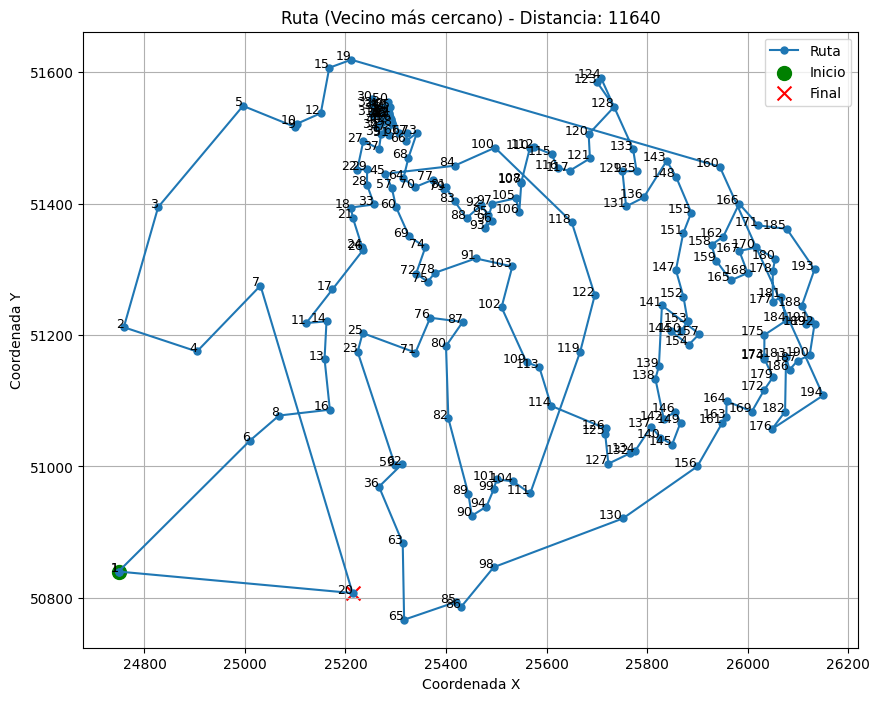

Ruta aproximada (Inserción más cercana): [1, 4, 6, 8, 11, 13, 16, 23, 25, 14, 17, 26, 24, 33, 69, 72, 76, 71, 36, 20, 65, 86, 85, 98, 111, 104, 101, 99, 94, 90, 89, 63, 59, 62, 82, 80, 87, 75, 78, 74, 60, 57, 70, 84, 88, 91, 102, 109, 114, 113, 119, 122, 103, 93, 96, 95, 106, 105, 108, 107, 118, 116, 117, 121, 129, 131, 136, 147, 141, 144, 139, 138, 137, 126, 125, 127, 130, 132, 134, 140, 145, 156, 142, 149, 146, 150, 154, 157, 153, 152, 159, 165, 167, 168, 177, 184, 183, 175, 173, 174, 179, 172, 164, 163, 161, 169, 176, 182, 194, 186, 187, 190, 189, 192, 191, 188, 193, 181, 178, 180, 185, 170, 171, 166, 160, 162, 158, 151, 155, 148, 143, 135, 133, 128, 124, 123, 120, 115, 112, 110, 100, 97, 92, 83, 79, 81, 77, 64, 68, 66, 73, 67, 61, 56, 48, 44, 50, 55, 49, 42, 19, 15, 5, 10, 9, 12, 30, 32, 31, 35, 38, 41, 46, 54, 52, 53, 43, 40, 34, 39, 47, 58, 51, 27, 37, 45, 29, 22, 28, 21, 18, 7, 3, 2, 1]
Distancia total aproximada (Inserción más cercana): 11267
Tiempo de ejecución (Inserción más 

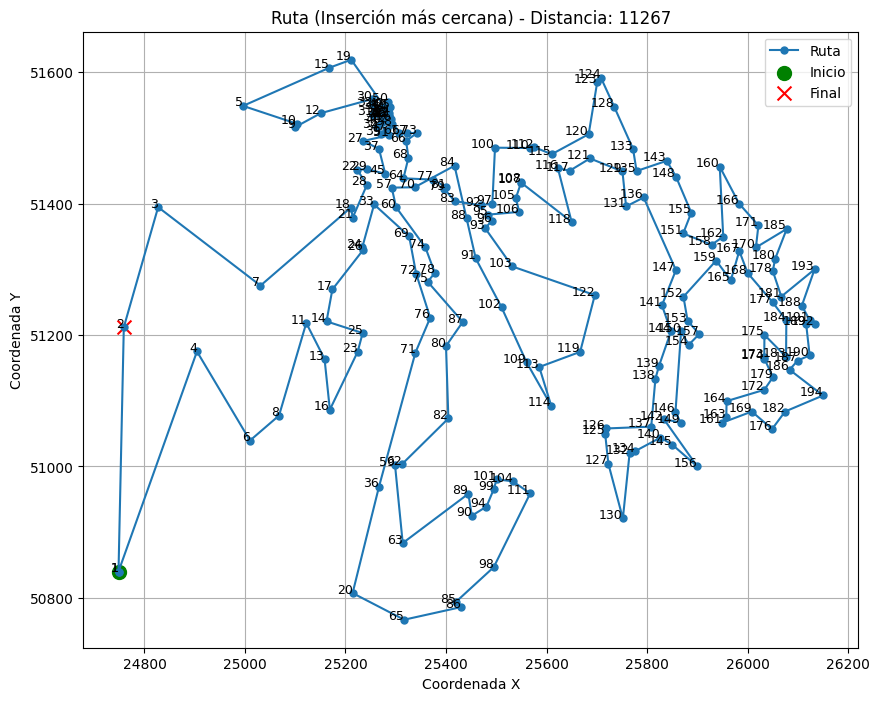

Ruta aproximada (2-opt): [1, 4, 2, 3, 5, 9, 10, 12, 15, 19, 30, 32, 31, 35, 42, 50, 55, 49, 44, 38, 41, 46, 48, 54, 52, 53, 56, 58, 67, 73, 66, 61, 51, 47, 43, 40, 34, 39, 27, 22, 18, 21, 24, 26, 74, 69, 33, 28, 29, 37, 45, 68, 64, 57, 60, 70, 77, 84, 81, 79, 83, 88, 92, 93, 96, 95, 97, 106, 105, 107, 108, 100, 110, 112, 115, 116, 117, 118, 121, 120, 123, 124, 128, 133, 129, 131, 136, 135, 143, 148, 160, 166, 171, 185, 180, 178, 177, 181, 193, 188, 184, 189, 191, 192, 190, 187, 186, 194, 182, 176, 156, 145, 140, 137, 134, 132, 126, 125, 127, 130, 111, 114, 119, 139, 138, 142, 146, 149, 161, 163, 164, 169, 172, 179, 183, 174, 173, 175, 168, 170, 167, 162, 158, 155, 151, 159, 165, 157, 154, 144, 150, 153, 152, 147, 141, 122, 113, 109, 102, 103, 91, 87, 78, 72, 75, 76, 71, 80, 82, 101, 104, 99, 94, 89, 90, 98, 86, 85, 65, 20, 63, 36, 59, 62, 16, 23, 25, 17, 14, 13, 11, 7, 8, 6, 1]
Distancia total aproximada (2-opt): 10446
Tiempo de ejecución (2-opt): 6.094444990158081 segundos
___________

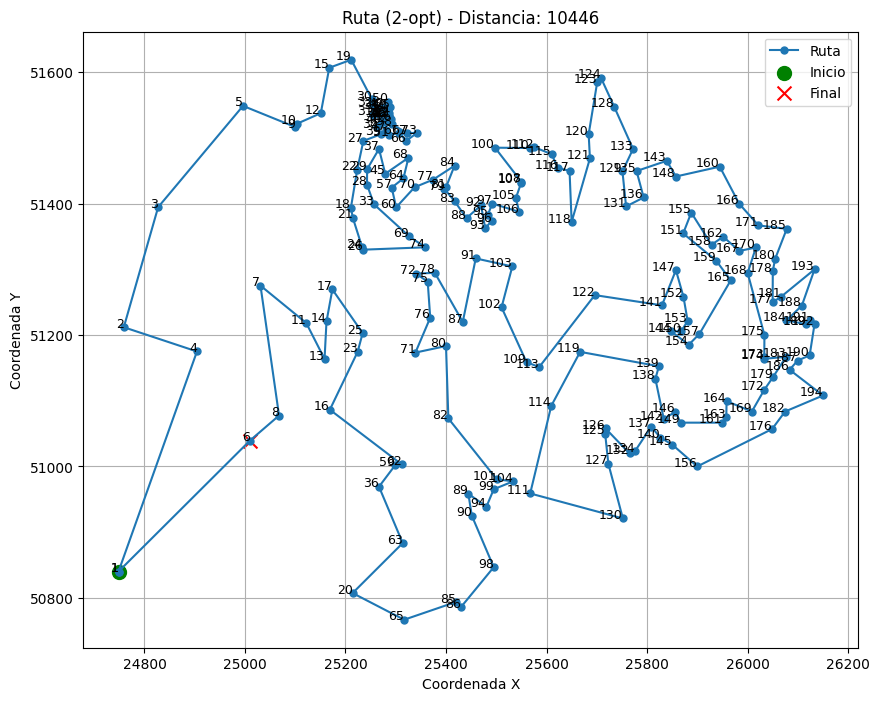

Ruta aproximada (Búsqueda Tabú): [186, 183, 175, 173, 174, 179, 172, 182, 176, 169, 164, 163, 161, 156, 145, 140, 142, 149, 146, 139, 138, 137, 134, 132, 126, 125, 127, 130, 111, 104, 101, 99, 94, 89, 90, 98, 86, 85, 65, 20, 63, 36, 59, 62, 82, 80, 71, 76, 75, 72, 69, 74, 78, 87, 91, 103, 102, 109, 113, 114, 119, 122, 118, 108, 107, 105, 106, 96, 93, 95, 97, 92, 88, 83, 79, 81, 77, 70, 64, 45, 57, 60, 33, 18, 21, 24, 26, 17, 7, 11, 14, 25, 23, 13, 16, 8, 6, 1, 4, 2, 3, 5, 9, 10, 12, 15, 19, 30, 32, 31, 35, 42, 50, 55, 49, 44, 54, 52, 53, 56, 58, 48, 46, 41, 38, 43, 40, 34, 27, 22, 28, 29, 37, 39, 47, 51, 61, 67, 73, 66, 68, 84, 100, 110, 112, 115, 116, 117, 121, 120, 123, 124, 128, 133, 135, 129, 131, 136, 143, 148, 155, 151, 147, 152, 141, 144, 150, 153, 154, 157, 165, 168, 167, 159, 158, 162, 160, 166, 171, 170, 185, 180, 178, 181, 177, 184, 188, 193, 192, 191, 189, 190, 194, 187, 186]
Distancia total aproximada (Búsqueda Tabú): 9691
Tiempo de ejecución (Búsqueda Tabú): 376.603402853

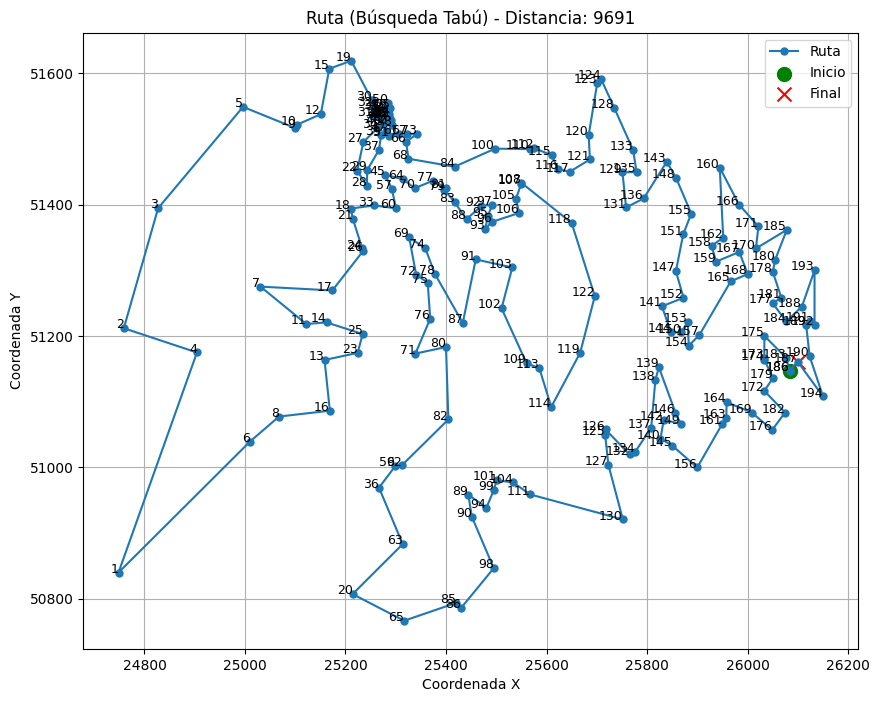

Ruta aproximada (Recocido Simulado): [139, 144, 150, 153, 154, 157, 175, 177, 181, 184, 183, 173, 174, 179, 172, 169, 176, 182, 194, 186, 187, 190, 192, 191, 189, 188, 193, 185, 171, 170, 180, 178, 168, 167, 165, 152, 141, 147, 159, 158, 162, 166, 160, 155, 151, 148, 143, 133, 129, 135, 136, 131, 118, 121, 128, 124, 123, 120, 117, 116, 115, 112, 110, 100, 108, 107, 105, 106, 97, 95, 96, 93, 103, 102, 91, 78, 74, 69, 60, 33, 28, 22, 29, 57, 45, 64, 70, 77, 79, 81, 83, 92, 88, 84, 68, 73, 67, 66, 61, 51, 47, 58, 56, 53, 52, 54, 55, 50, 49, 42, 44, 35, 38, 41, 46, 48, 43, 40, 34, 39, 37, 27, 31, 32, 30, 19, 15, 12, 10, 9, 5, 3, 2, 1, 6, 8, 16, 13, 23, 25, 14, 11, 4, 7, 17, 18, 21, 24, 26, 72, 75, 76, 71, 80, 87, 109, 113, 114, 119, 122, 126, 125, 111, 104, 101, 99, 94, 90, 89, 82, 59, 62, 36, 63, 20, 65, 85, 86, 98, 130, 127, 132, 134, 137, 140, 145, 149, 156, 161, 163, 164, 146, 142, 138, 139]
Distancia total aproximada (Recocido Simulado): 10560
Tiempo de ejecución (Recocido Simulado): 

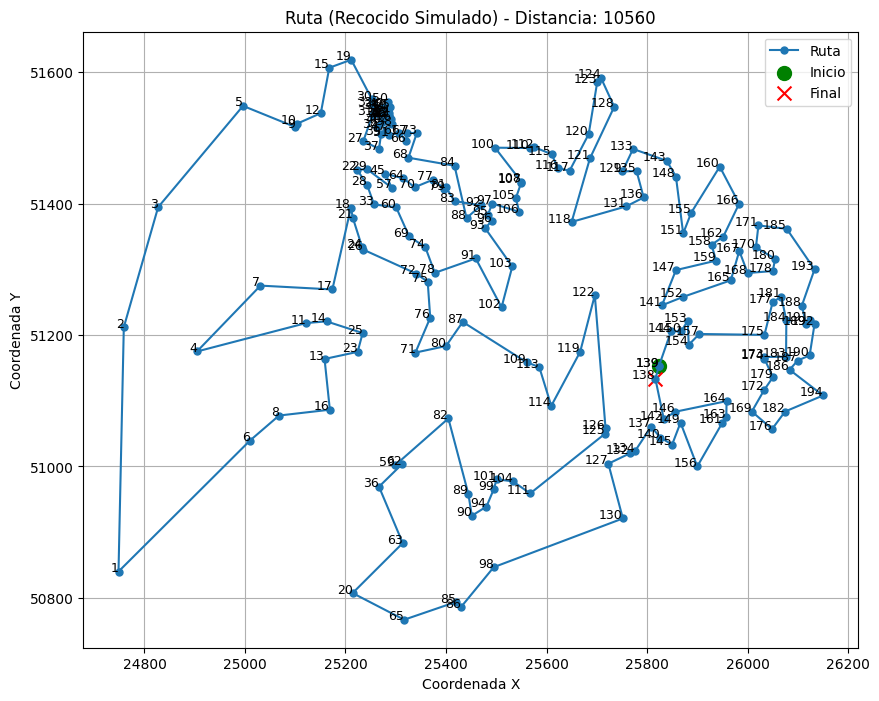

In [33]:
def main():
    # Archivo con las coordenadas de las ciudades
    file_path = 'Qatar.txt'
    cities = read_coordinates(file_path)

    # Crear la matriz de distancias
    distance_matrix, city_ids = create_distance_matrix(cities)

    # Aplicar heurísticas y graficar las rutas
    heuristics = [
        (nearest_neighbor_heuristic, "Vecino más cercano"),
        (nearest_insertion_heuristic, "Inserción más cercana"),
        (two_opt_heuristic, "2-opt"),
        (tabu_search, "Búsqueda Tabú"),
        (simulated_annealing, "Recocido Simulado")
    ]

    for heuristic, title in heuristics:
        start = time.time()
        route, total_distance = heuristic(distance_matrix, city_ids)
        end = time.time()

        print(f"Ruta aproximada ({title}):", route)
        print(f"Distancia total aproximada ({title}):", total_distance)
        print(f"Tiempo de ejecución ({title}): {end - start} segundos")
        print("__________________________________________________________________")

        plot_route(cities, route, f"Ruta ({title}) - Distancia: {total_distance}")

if __name__ == "__main__":
    main()